<p style="text-align: center;font-size: 60px;">Stars</p>
<br\><br\>
PLAsTiCC Astronomical Classification<br/>
https://www.kaggle.com/c/PLAsTiCC-2018

1. Problem: Can we idnetify star's type based on observed information? 
2. Goal: Categorize star type based on their constant properties and light ratio changes in different passbands
3. Evaluation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from random import shuffle

## Load MetaData and TimeSeries Data--edit your file path here

In [7]:
# Load and Show Training Metatata
# tm: train_metadata
TM = pd.read_csv('training_set_metadata.csv')
# print(TM.shape[0])
# TM.sort_values(by=['object_id'], ascending=True).head(10)
TS=pd.read_csv('training_set.csv')
# print(TS.shape[0])
# TS.sort_values(by=['object_id'],ascending=True).head(10)

In [8]:
len(TM.object_id.unique())
# TM.sort_values(by=['object_id'], ascending=True).head(10)

7848

## Preprocess Steps
1. For target class in MetaData, divide trainging and testing by 70% and 30%
1. For non-target class, use bootstrapping sampling method to generate training sample (non-selected)
1. For the rest of them, join to testing dataset as non-target class
1. For now there's no k-fold cross validation here
1. For the target class in training dataset, choose some object_id, shows the time-series pattern to analyze possible featrues. Require to merge the training target into timesries data first.

In [9]:
# get the distribution of each class first
distribution={}
for index, row in TM.iterrows():
    target=row['target']
    if target not in distribution:
        distribution[target]={}
        distribution[target]['member']=[]
        distribution[target]['proportion']=0.0
    distribution[target]['member'].append(row['object_id'])

total_obj=len(TM.object_id.unique())
for target in distribution:
    sub_len=len(distribution[target]['member'])
    distribution[target]['proportion']=sub_len/total_obj

## For each target class, seperate data into training set(70%) and validataion set(30%)

In [10]:
def split_train_validation(df, validation_ratio,distribution,target):
    ''' split data into train set and validation set for each target class'''
    
    train = pd.DataFrame(columns=df.columns)
    validation = pd.DataFrame(columns=df.columns)
    target_member=distribution[target]['member']
    shuffle(target_member)
    thres=len(target_member)*(1-validation_ratio)
    for i in range(len(target_member)):
        if i <= thres:
            train=train.append(df[df['object_id']==target_member[i]],ignore_index=True)
        else:
            validation=validation.append(df[df['object_id']==target_member[i]],ignore_index=True)
    # now for all other target class, extract training sample in the same distribution, with a total amount equal to 
    # target numbers which is thres
#     print(len(train.object_id.unique()))
#     print(len(validation.object_id.unique()))
    for t in distribution:
        if t!=target:
            t_member=distribution[t]['member']
            shuffle(t_member)
            # for training dataset
            sub_thres=thres*distribution[t]['proportion']
            for i in range(len(t_member)):
                if i <= sub_thres:
                    train=train.append(df[df['object_id']==t_member[i]],ignore_index=True)
                else:
                    validation=validation.append(df[df['object_id']==t_member[i]],ignore_index=True)
    
    
#     print(len(train.object_id.unique()))
#     print(len(validation.object_id.unique()))
    return train.drop(['ra','decl','gal_l','gal_b','ddf','hostgal_specz','hostgal_photoz','hostgal_photoz_err','distmod','mwebv'],axis=1),\
validation.drop(['ra','decl','gal_l','gal_b','ddf','hostgal_specz','hostgal_photoz','hostgal_photoz_err','distmod','mwebv'],axis=1)
#     targets = sorted(list(df['target'].unique()))
#     np.random.seed(4)
#     for target in targets:
#         sub_df = df[df['target']==target].sort_values(by=['object_id'])
        
#         msk = np.random.rand(len(sub_df)) > validation_ratio
#         train = train.append(sub_df[msk], ignore_index=True)
#         validation = validation.append(sub_df[~msk], ignore_index=True)
        
#     train.sort_values(by=['object_id'], inplace=True)
#     validation.sort_values(by=['object_id'], inplace=True)
#     return train.drop(['target'], axis=1), train[['target']], validation.drop(['target'], axis=1), validation[['target']]


In [11]:
# change the target number as the last parameter
mytrain, myval=split_train_validation(TM,0.3,distribution,88)

In [12]:
# this part is for testing the distribution fit, you don't have to run this
# test_dist={}
# for index, row in mytrain.iterrows():
#     target=row['target']
#     if target not in test_dist:
#         test_dist[target]={}
#         test_dist[target]['member']=[]
#         test_dist[target]['proportion']=0.0
#     test_dist[target]['member'].append(row['object_id'])

# mytotal_obj=len(mytrain.object_id.unique())/2
# print(mytotal_obj)
# for target in test_dist:
#     sub_len=len(test_dist[target]['member'])
#     test_dist[target]['proportion']=sub_len/mytotal_obj
#     print(test_dist[target]['proportion']," ",distribution[target]['proportion'])

In [13]:
# combine training dataset and validation dataset into time-series data, rename the variable as you want
mytrain_2=pd.merge(mytrain,TS,how='right',on=['object_id'])
myval_2=pd.merge(myval,TS,how='right',on=['object_id'])

In [14]:
# you don't have to run this, this is for checking the result
# mytrain_2.head()
# TS[TS['object_id']==22083479]
# myval[myval['object_id']==22083479]
# mytrain_2[mytrain_2['object_id']==22083479]
# myval_2[myval_2['object_id']==22083479]

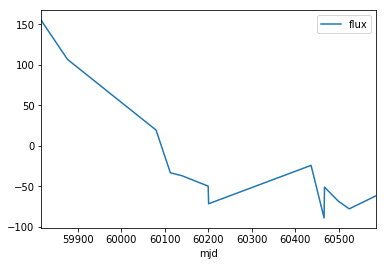

In [15]:
# now try to draw the pattern from time-series data, pick the first object from training dataset, 
# change the passband as you want
randobj=mytrain_2.object_id.unique()[0]
train_randobj_1=mytrain_2[(mytrain_2['object_id']==randobj) & (mytrain_2['passband']==0)]
train_randobj_1.head()
train_randobj_1.drop(['object_id','passband','flux_err','detected','target'],axis=1).plot(x='mjd',y='flux')